<a href="https://colab.research.google.com/github/albertaillet/LELSD/blob/colab-setup/notebooks/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Clone repo and from correct branch
*   Download the pretrained stylegan2 model from https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/






In [1]:
!git clone --branch colab-setup https://github.com/albertaillet/LELSD/
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P LELSD/pretrained/stylegan2

fatal: destination path 'LELSD' already exists and is not an empty directory.
--2022-04-01 14:19:17--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 143.204.231.104, 143.204.231.38, 143.204.231.29, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|143.204.231.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘LELSD/pretrained/stylegan2/ffhq.pkl.1’

ffhq.pkl.1          100%[===================>] 363.94M   164MB/s    in 2.2s    

2022-04-01 14:19:19 (164 MB/s) - ‘LELSD/pretrained/stylegan2/ffhq.pkl.1’ saved [381624121/381624121]



In [2]:
!pip install -r LELSD/requirements.txt
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3a40l5yj
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-3a40l5yj


In [3]:
%cd LELSD

/content/LELSD


In [4]:
#%load_ext autoreload
#%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import sys
import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image 

import models
from utils.stylegan2_utils import StyleGAN2SampleGenerator
from lelsd import LELSD


In [5]:
device = torch.device('cuda')

exp_dir = "out"
G2 = models.get_model("stylegan2", "pretrained/stylegan2/ffhq.pkl")
sample_generator = StyleGAN2SampleGenerator(G=G2, device=device)

In [14]:
seed = 4
batch_data = sample_generator.generate_batch(seed, return_image=True, batch_size=1)

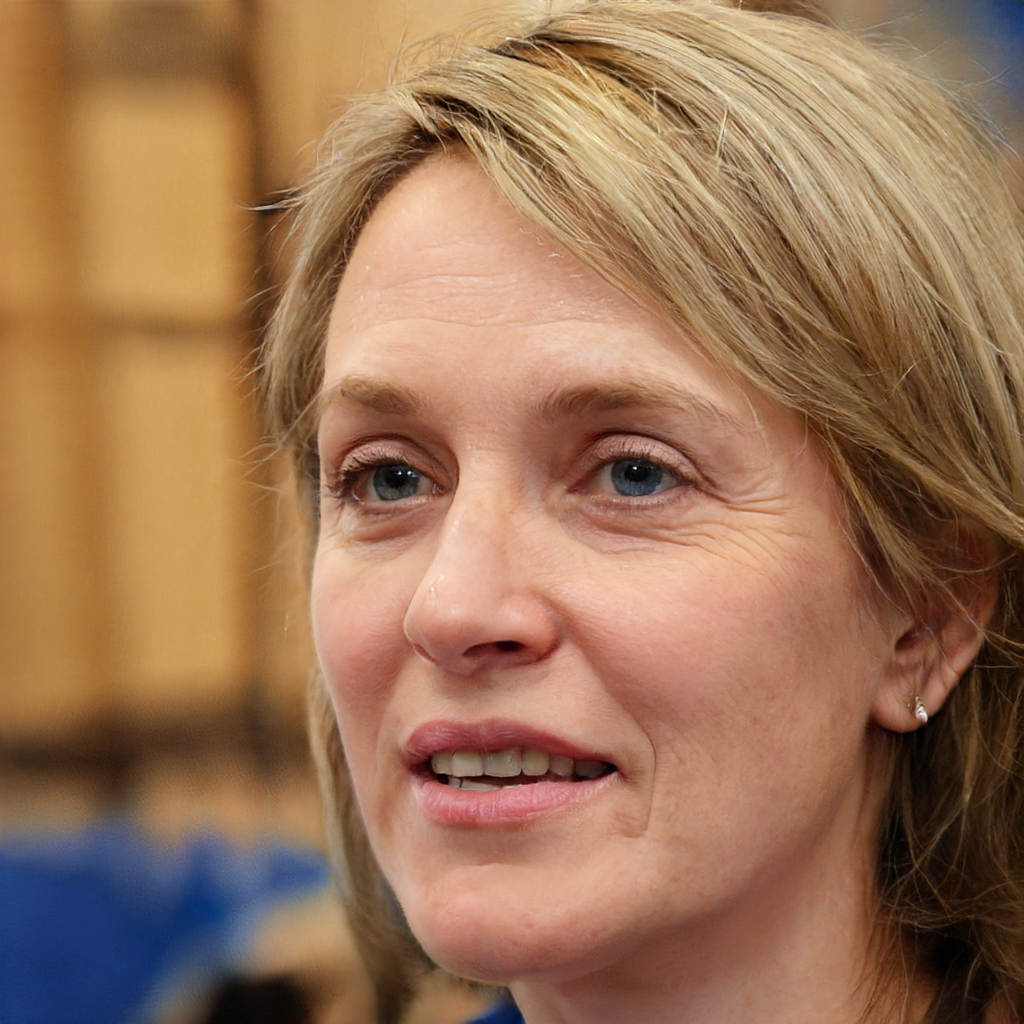

In [26]:
batch_data["image"][0]

In [17]:
ws = batch_data["ws"]

In [21]:
ws[:, 1, :] += 2

In [23]:
new_batch_data = sample_generator.generate_batch_from_ws(ws, return_image=True)

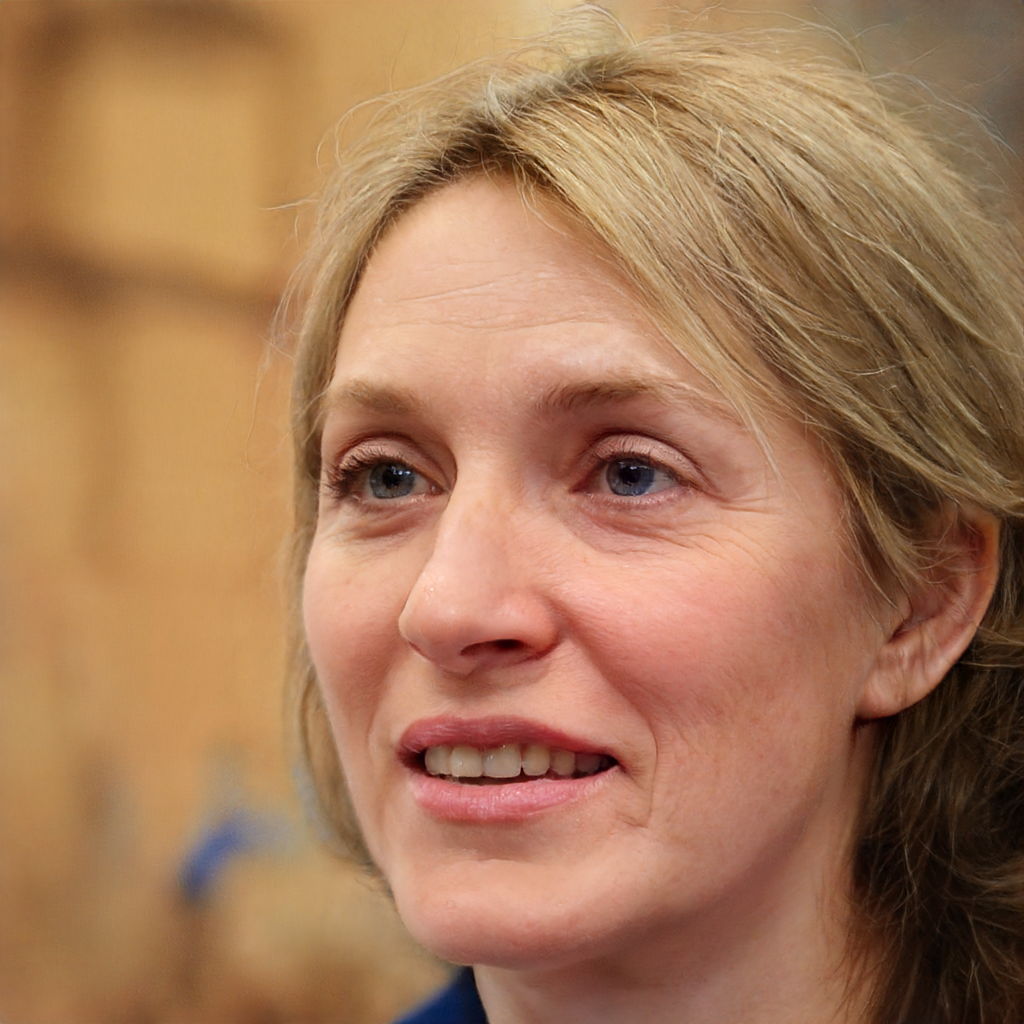

In [25]:
new_batch_data["image"][0]